# Namaph-Sim Model
- u ... physical qty / vector
- D ... diffusion coef / vector
- r ... interaction coef / matrix
- k ... flow io coef / vector
- f(r, u) ... reaction fn
- f(u) ... flow io fn

$$
\begin{align*}
\begin{aligned}
u &= (u_1, u_2, ..., u_n)\\
d &= (d_1, d_2, ..., d_n) \\
r &= \begin{pmatrix}\\
&r_{11},  &\cdots &r_{1n} \\
&\vdots  &\ddots &\vdots \\
&r_{n1},  &\cdots &r_{nn} \\
\end{pmatrix} \\
k &= (k_1, k_2, ..., k_n) \\
\frac{\partial u_i}{\partial t} &= d_i \Delta u_i + f(r, u) + g(k, u)\\
\end{aligned}
\end{align*}
$$

the most simplest $f(r, u)$ case is no-interaction, linear model
$$ \frac{\partial u}{\partial t} = d \cdot \Delta u + r_{(i, \cdot)} \cdot u - (1-k) \cdot u$$

other examples
- Gray Scott (non-linear, 2var simulation)
  - $\frac{\partial u}{\partial t} = D_u \Delta u - uv^2 + F(1-u)$
  - $\frac{\partial v}{\partial t} = D_v \Delta v + uv^2 - (F+k)v$
- Lotka Volterra (non-linear, 2var simulation)
  - $\frac{dN_1}{dt} = N_1(r_1 - \gamma_{12} N_2 - \beta_1N_1) = (r_1N_1 - \gamma_{12} N_1N_2 - \beta_1N_1^2)$
  - $\frac{dN_2}{dt} = N_2(r_2 - \gamma_{21}N_1  - \beta_2N_2) = (r_2N_2 - \gamma_{21}N_1N_2 - \beta_2N_2^2)$

laplacian is given by 

$$\Delta u_{t}^{(x,y)} = \frac{1}{(\Delta x)^2} (u_{t}^{(x,y-1)} + u_{t}^{(x-1,y)} -4u_{t}^{(x,y)} + u_{t}^{(x+1,y)} + u_{t}^{(x,y+1)})$$

and discretization of this model is 

$$u_{t+1}^{(x,y)} = u_{t}^{(x,y)} + \Delta t \lbrace d\cdot \Delta u_t^{(x,y)} - f(r, u_t^{(x,y)}) + g(k, u_t^{(x,y)}) \rbrace$$

FTCS(forward in time centered in space) scheme

In [1]:
from dataclasses import dataclass
from enum import Enum
from typing import Any

import numpy as np
import numpy.typing as npt
from tqdm.notebook import tqdm

import pandas as pd

In [2]:
Grid3D = npt.NDArray[float]

class LaplacianMode(Enum):
    neumann = "neumann"
    moore = "moore"

class BoundaryCondition(Enum):
    periodic = "periodic"
    dirichlet = "dirichlet"
    neumann = "neumann"

class History():
    name: list[str]
    def __init__(self, *args) -> None:
        self.name = args
        for arg in args:
            setattr(self, arg, [])
    
    def append(self, **kwargs) -> None:
        for k, v in kwargs.items():
            getattr(self, k).append(v)
    
    def __repr__(self) -> str:
        return f"History({self.name})"
        
    
class NamaphSim3D():
    dt: float
    dx: float
    
    def __init__(self, dt: float, dx: float) -> None:
        self.dt = dt
        self.dx = dx
    
    def init_boundary(
        self,
        fields: Grid3D,
        mode: BoundaryCondition=BoundaryCondition.periodic,
        **option: dict[str, int|float|npt.NDArray]
    ) -> Grid3D:
        z, x, y = field.shape
        new_field = np.zeros((z, x+2, y+2))
        new_field[:, 1:-1, 1:-1] = field
        return self.update_boundary(new_field, mode, **option)
    
    def laplacian(
        self,
        field: Grid3D,
        mode: LaplacianMode=LaplacianMode.moore
    ) -> Grid3D:
        mu = self.dx**2
        match mode:
            case LaplacianMode.neumann:
                val = mu * self.neumann_nbhd(field)
                return np.pad(val, [(0,), (1,), (1,)], "constant")
            case LaplacianMode.moore:
                val = mu * self.moore_nbhd(field)
                return np.pad(val, [(0,), (1,), (1,)], "constant")
    
    def update_boundary(
        self,
        field: Grid3D,
        mode: BoundaryCondition=BoundaryCondition.periodic,
        **option: dict[str, int|float|npt.NDArray]
    ):
        match mode:
            case BoundaryCondition.periodic:
                return self.periodic_bc(field)
            case BoundaryCondition.dirichlet:
                return self.dirichlet_bc(field, option['value'])
            case BoundaryCondition.neumann:
                return self.neumann_bc(field)
    
    def neumann_nbhd(self, u: Grid3D) -> Grid3D:
        ret =  (                     u[:,  :-2, 1:-1] +
                 u[:, 1:-1, :-2] - 4*u[:, 1:-1, 1:-1] + u[:, 1:-1, 2:]
                                 +   u[:, 2:  , 1:-1]                  )
        return ret
    
    def moore_nbhd(self, u: Grid3D) -> Grid3D:
        ret =  ( u[:,  :-2, :-2] +   u[:,  :-2, 1:-1] + u[:,  :-2, 2:] +
                 u[:, 1:-1, :-2] - 8*u[:, 1:-1, 1:-1] + u[:, 1:-1, 2:] +
                 u[:, 2:  , :-2] +   u[:, 2:  , 1:-1] + u[:, 2:  , 2:] )
        return ret
    
    def periodic_bc(self, u: Grid3D) -> Grid3D:
        # Check: values in the corner would be assigned twice.
        u[:, [0,-1], :     ] = u[:, [-2,1], :     ]
        u[:, :     , [0,-1]] = u[:, :     , [-2,1]]
        return u
    
    def dirichlet_bc(self, u:Grid3D, value:npt.NDArray) -> Grid3D:
        u[:, [0,-1], :     ] = value[0], value[1]
        u[:, :     , [0,-1]] = value[2], value[3]
        return u
    
    def neumann_bc(self, u:Grid3D) -> Grid3D:
        u[:, [0,-1], :     ] = u[:, [1,-2], :     ]
        u[:, :     , [0,-1]] = u[:, :     , [1,-2]]
        return u

In [3]:
@dataclass
class CALotkaParams:
    dt: float
    dx: float
    
    DiffusionRate: npt.NDArray
    InteractionValue: npt.NDArray
    
class CALotka(NamaphSim3D):
    D: npt.NDArray
    R: npt.NDArray
    
    def __init__(self, params: CALotkaParams) -> None:
        super().__init__(params.dt, params.dx)
        r_shape = params.InteractionValue.shape
        self.D = params.DiffusionRate.reshape(-1, 1, 1)
        self.R = params.InteractionValue.reshape(*r_shape, 1, 1)
    
    def diffuse(self, fields: Grid3D, mode: LaplacianMode) -> Grid3D:
        return self.D * self.laplacian(fields, mode)
    
    def react(self, fields: Grid3D) -> Grid3D:
        return (self.R * fields).sum(1)
    
    def flow(self, fields: Grid3D) -> Grid3D:
        return 0
    
    def step(self, fields: Grid3D, mode:LaplacianMode) -> Grid3D:
        d = self.diffuse(fields, mode)
        r = self.react(fields)
        f = self.flow(fields)
        return self.update_boundary(fields+self.dt*(d+r+f))
    
    def run(
        self,
        fields: Grid3D,
        n_iter: int = 100,
        n_per_record: int = 10
    ) -> Grid3D:
        f = self.init_boundary(fields)
        gif = lambda k: np.uint8(255*(k-k.min()) / (k.max()-k.min()))
        
        hist = History('fields', 'gif')
        hist.append(fields = f, gif = gif(f))
                        
        for t in tqdm(range(n_iter)):
            f = self.step(f, LaplacianMode.moore)
            hist.append(fields = f)
            if t % n_per_record == 0:
                hist.append(gif = gif(f))
        return hist

In [4]:
def init(n=10):
    m = n//2
    field = np.zeros((4, n, n))
    field[0, :m, :m] = 0.5
    field[1, m:, :m] = 0.5
    field[2, :m, m:] = 0.5
    field[3, m:, m:] = 0.5
    return field

In [5]:
coef = pd.DataFrame({
    'Office': [0, -0.5, 0.5, 0.25],
    'Housing': [-0.5, 0, 0.75, 0.75],
    'Amenities': [0.75, -0.2, 0, 0],
    'OpenSpace': [-0.2, -0.2, -0.2, 0]
})

params = CALotkaParams(
    dt = 1,
    dx = 1,
    
    DiffusionRate = np.array([0.01, 0.05, 0.01, 0.02]),
    InteractionValue = coef.values,
)

field = init(300)

model = CALotka(params)
result = model.run(field, n_iter=250, n_per_record=1)

  0%|          | 0/250 [00:00<?, ?it/s]

In [22]:
from PIL import Image
from ipywidgets import interact, IntSlider
import imageio

# imageio.mimsave('./output/grayscott.gif', result.gif, format='gif', fps=60)

target = t

interact(
    lambda iframe: Image.fromarray(result.gif[iframe][target, :, :]), 
    iframe = IntSlider(
        min=0,
        max=len(result.gif)-1,
        step=1,
        value=0, 
        continuous_update=True)
) 

interactive(children=(IntSlider(value=0, description='iframe', max=250), Output()), _dom_classes=('widget-inte…

<function __main__.<lambda>(iframe)>

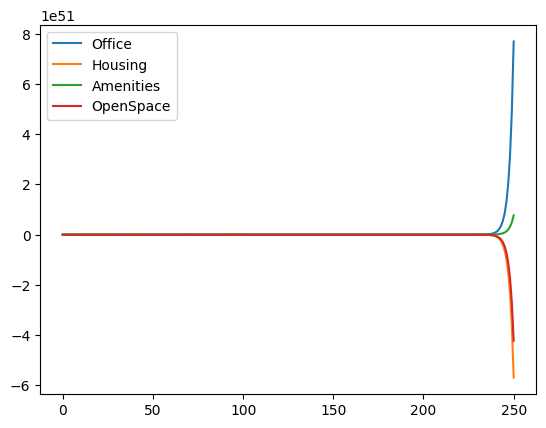

In [48]:
import matplotlib.pyplot as plt

# we know the size of this array
totalpertime = [ [0.0]* len(result.fields) for i in range(len(result.fields[0]))]

for i in range(len(result.fields)) :
    for (j, iss) in enumerate(result.fields[i]) :
        totalpertime[j][i] = iss.sum()

totals = pd.DataFrame({names: sums for names,
            sums in zip(coef.keys(), totalpertime)})

totals.plot()
plt.show()